# Importing the data

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import folium
import contextily as ctx

from geopy.distance import great_circle
from sklearn.cluster import DBSCAN as dbscan
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('../data/data_mmda_traffic_spatial_cleaned.csv')

### Create GeoDateFrame from DataFrame

In [3]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
gdf.crs = 'EPSG:4326'

### Import the spatial data for the boundary of the cities in Metro Manila

In [4]:
boundaries = gpd.read_file('../data/boundary_ncr/cleaned/boundary_ncr.shp')

# Perform the spatial join
accident_boundaries = gpd.sjoin(
    boundaries, gdf, predicate='contains', ).dropna()

# Select only the cities where accidents happened on our dataset
boundaries = boundaries[boundaries.index.isin(accident_boundaries.index)]
boundaries.reset_index(inplace=True, drop=True)

# Preparing the model
We will use the DBSCAN model to cluster vehicular accident hotspots in Metro Manila. This model is a density-based clustering model which means it will cluster points that are closer or packed together which is good for finding hotspots.

### Using geopy's great_circle method
To calculate the distance between points in DBSCAN, we will create a function that uses the latitude and longitude of two points and the great_circle function from geopy to determine the distance in meters, taking into account the curvature of the Earth.

In [5]:
def greatcircle(x, y):
    """
    Uses the latitude and longitude of two points and the great_circle function from geopy to determine the distance in meters, taking into account the curvature of the Earth.
    """
    lat1, long1 = x[0], x[1]
    lat2, long2 = y[0], y[1]
    dist = great_circle((lat1, long1), (lat2, long2)).meters
    return dist

### Finding the optimal eps
To find the optimal eps value for DBSCAN, we can use KNN and plot the distances between each point and its nearest neighbors and use the "knee" in the curve as a rough estimate of eps.

For more information (https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc)

In [6]:
coordinates = df[['Latitude', 'Longitude']].values

neigh = NearestNeighbors(n_neighbors=2, metric=greatcircle)
nbrs = neigh.fit(coordinates)

distances, indices = nbrs.kneighbors(coordinates)

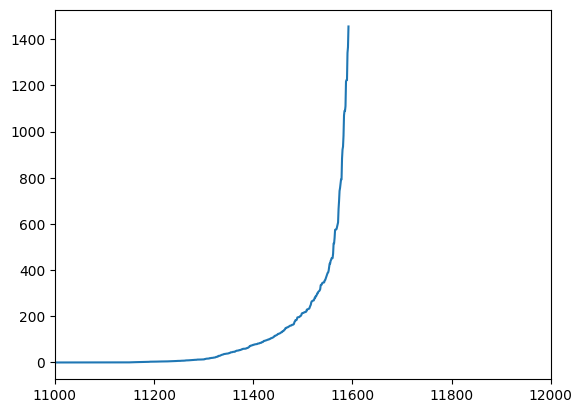

In [7]:
fig, ax = plt.subplots()

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.plot(distances)
ax.set_xlim(11000, 12000)
plt.show()

We can estimate a value of eps = *200* by looking at the knee (where the distance begin to increase more rapidly) of this plot.

### Training the model
Now we can train the model using the coordinates on our dataset to cluster vehicular accidents by their location.

In [8]:
# Setting hyperparameters
eps = 200
min_samples = 100

loc = df[['Latitude', 'Longitude']]

# Training the model
dbc = dbscan(eps=eps, min_samples=min_samples, metric=greatcircle).fit(loc)

In [9]:
labels = dbc.labels_
df['Cluster'] = labels

unique_labels = np.unique(labels)
unique_labels


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33])

### Visualize clusters (Using contextily)

In [27]:
gdf['Cluster'] = labels

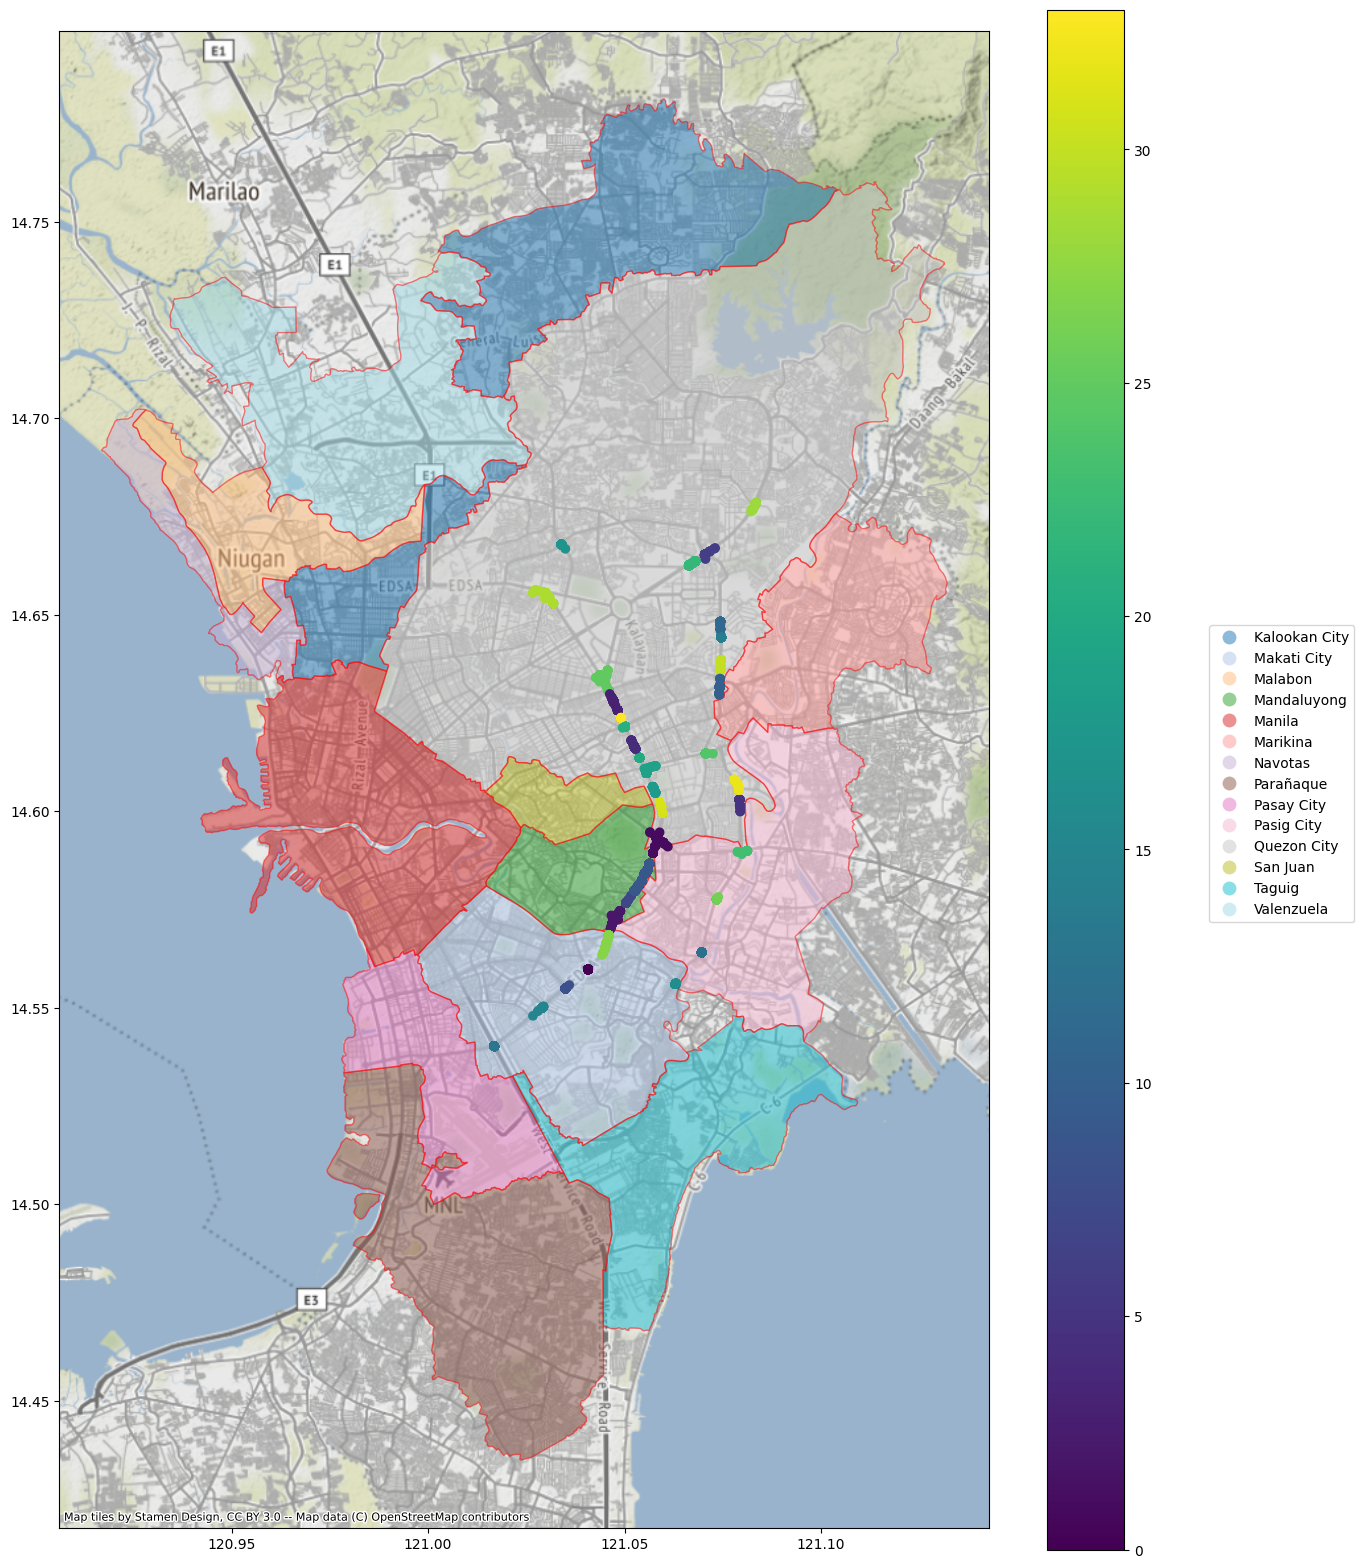

In [30]:
gdf_copy = gdf.drop(gdf[gdf['Cluster'] == -1].index, axis=0)

fig, ax = plt.subplots(figsize=(15, 20))
boundaries.plot(column='NAME_2', edgecolor='red', ax=ax, alpha=0.5,
                legend=True, legend_kwds={"loc": "lower right", "bbox_to_anchor": (1.4, 0.4)}, cmap='tab20')
gdf_copy.plot(ax=ax, column='Cluster', legend=True)
ctx.add_basemap(ax=ax, crs=gdf.crs)
plt.show()

In [23]:
c9 = gdf_copy[gdf_copy['Cluster'] == 19]
c9['City'].unique()


array(['Quezon City'], dtype=object)